# Integrative analysis of pathway deregulation in obesity #

## Python implementation

### Batch Effect Evaluation

1. We have to integrate all the 4 output of the pre-processing step on the previous 4 batches;
2. Perform a PCA evaluation and see that samples can be defined alog components that can be considered as the belonging to each batch;
3. Perform a SVD approach to eliminate batch effect;
4. Perform again PCA and show that the samples can be described using only 2 principal component that should be being lean or obese

### Imports

In [1]:
# Import std libraries
import os
from operator import itemgetter 
import re

# Import third party
import numpy as np
import scipy as sp
from numpy import *
import pandas as pd
import GEOparse
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

# import plotting tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

# Set logging
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logging.getLogger("GEOparse").setLevel(logging.WARNING)

plot_dir_path = './plots/'
if not os.path.exists(plot_dir_path):
    os.makedirs(plot_dir_path)
    print('created ./path directory')
    
# enable matplotlib inline
%matplotlib inline

### Load Datasets

Dataset are loaded from .pkl file created in a previous step of the pre-processing phase.

In the .pkl file there will be and index (GENE_ENTREZ_ID) and the sample taken into accout in the dataset

In [2]:
suffix = "_table.pkl"
list_of_dataset_to_load = ["GSE2508", "GSE26637", "GSE27949", "GSE48964"]
batches_df = []
person_batch_index = []
for i, batch_name in enumerate(list_of_dataset_to_load):
    current_df = pd.read_pickle('../1. pre-processing/data/' + batch_name + suffix)
    current_shape = current_df.shape
    person_batch_index += [(i+1)]*current_shape[1]
    print(batch_name, current_shape, 'is index unique? ->', current_df.index.is_unique)
    batches_df.append(current_df)

merged_df = pd.concat(batches_df, axis='columns')
merged_df = merged_df.dropna(axis='rows', how='any')
print("", merged_df.shape)
merged_df.head()

GSE2508 (18280, 39) is index unique? -> True
GSE26637 (20486, 20) is index unique? -> True
GSE27949 (20486, 23) is index unique? -> True
GSE48964 (19037, 6) is index unique? -> True
 (15452, 88)


,GSM47301_LM,GSM47856_OM,GSM47568_LF,GSM47840_LM,GSM47362_LM,GSM47581_OF,GSM47372_OF,GSM47395_LF,GSM47561_LF,GSM47326_OF,...,GSM691126_OU,GSM691154_LU,GSM691134_OU,GSM691144_OU,GSM1187676_LU,GSM1187673_OU,GSM1187674_OU,GSM1187678_LU,GSM1187675_OU,GSM1187677_LU
1,-14.333303,-13.137120,-13.390124,-15.177814,-13.535999,-13.198388,-13.376763,-15.204678,-13.313768,-15.188506,...,-17.002924,-17.219474,-17.365789,-17.142668,-15.411493,-15.371411,-15.287002,-15.465073,-15.509755,-15.446053
10,-17.913243,-18.478254,-18.356992,-19.541172,-19.251524,-16.656797,-19.417744,-18.514169,-16.296373,-18.957014,...,-17.292170,-16.936701,-17.048590,-17.194503,-18.802493,-18.917941,-18.506202,-18.633493,-18.888015,-18.660593
100,-14.352948,-14.386996,-14.852295,-14.737911,-14.208276,-14.859601,-13.958755,-14.962105,-14.469576,-14.178614,...,-15.146958,-14.924284,-15.921903,-15.019982,-13.314273,-13.578881,-13.921932,-13.775873,-13.433345,-13.045083
1000,-15.370801,-15.667994,-16.422555,-15.798042,-15.806323,-16.521828,-15.535281,-15.639368,-15.690821,-16.757663,...,-17.451344,-17.332248,-17.216601,-17.425703,-13.250773,-10.870481,-11.022812,-10.976913,-11.228445,-11.044883
10000,-15.274287,-15.023897,-14.882516,-14.632519,-15.354033,-14.912501,-14.708296,-15.804482,-15.755244,-15.212492,...,-16.177538,-15.829951,-16.789228,-15.988975,-13.432973,-13.104581,-13.278812,-13.372513,-13.361845,-13.304883


### Applying a PCA to the merged datasets

We need the merged_df to show that there is batch effect to remove. This is done using a PCA and plotting the first 3 componenets. The plots below shows that we have a cluster per batch rather than an uniform distributions of the sample in the space.

REFERENCE:
https://plot.ly/ipython-notebooks/principal-component-analysis/

In [3]:
# Because we are interested in collapse the dimension of the sample and not the one of the genes
merged_df_t = merged_df.transpose()

# apply a Standardization first
merged_df_std = StandardScaler().fit_transform(merged_df_t)

# define the PCA object, using 3 components
pca = PCA(n_components=3, svd_solver="full", whiten=True)

# apply the PCA on our dataset
pca_trans = pca.fit_transform(merged_df_std)
print('variance_ratio', pca.explained_variance_ratio_)
print('variance', pca.explained_variance_)

# create a dataframe from pca results
pca_trans_df = pd.DataFrame(data=pca_trans, index=merged_df_t.index)

# plot pca results with respect to lean and obese subjects
# red: lean subjects
# blue: obese subjects
indexes = merged_df_t.index
lean_or_obese_color = []
for el in indexes:
    if "L" in el:
        lean_or_obese_color.append('r')
    elif "O" in el:
        lean_or_obese_color.append('b')
    
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
red_patch = mpatches.Patch(color='red', label='Lean')
blue_patch = mpatches.Patch(color='blue', label='Obese')
ax.scatter(pca_trans_df[0], pca_trans_df[1], pca_trans_df[2], c=lean_or_obese_color)
ax.set_xlabel('X: PCA-C1')
ax.set_ylabel('Y: PCA-C2')
ax.set_zlabel('Z: PCA-C3')
plt.title("PCA plot respect obese or lean subject")
plt.legend(handles=[red_patch, blue_patch])
plt.savefig(plot_dir_path + 'PCA_O-L_std.pdf', format="pdf")
print("-> Created 3D plot in ./plot/PCA_O-L_std.pdf")
plt.close(fig)


# plot pca results with respect to the gender
# red: male
# blue: female
# yellow: undefined
male_or_female_or_unknown_color = []
for el in indexes:
    if "F" in el:
        male_or_female_or_unknown_color.append('b')
    elif "U" in el:
        male_or_female_or_unknown_color.append('y')
    elif "M" in el:
        male_or_female_or_unknown_color.append('r')

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
red_patch = mpatches.Patch(color='red', label='Male')
blue_patch = mpatches.Patch(color='blue', label='Female')
yellow_patch = mpatches.Patch(color='yellow', label='Undefined')
ax.scatter(pca_trans_df[0], pca_trans_df[1], pca_trans_df[2], c=male_or_female_or_unknown_color)
ax.set_xlabel('X: PCA-C1')
ax.set_ylabel('Y: PCA-C2')
ax.set_zlabel('Z: PCA-C3')
plt.title("PCA plot respect to sex")
plt.legend(handles=[red_patch, blue_patch, yellow_patch])
plt.savefig(plot_dir_path + 'PCA_M_F_U_std.pdf', format="pdf")
plt.close(fig)
print("-> Created 3D plot in ./plot/PCA_M_F_U_std.pdf")

# plot pca results with respect to the batch
batch_color = []
dict_of_colors = {}

list_of_colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', 'w']
color_per_sample = [list_of_colors[x] for x in person_batch_index]

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
blue_patch = mpatches.Patch(color='blue', label='GSE2508')
green_patch = mpatches.Patch(color='green', label='GSE26637')
red_patch = mpatches.Patch(color='red', label='GSE27949')
yellow_patch = mpatches.Patch(color='yellow', label='GSE48964')
ax.scatter(pca_trans_df[0], pca_trans_df[1], pca_trans_df[2], c=color_per_sample)
ax.set_xlabel('X: PCA-C1')
ax.set_ylabel('Y: PCA-C2')
ax.set_zlabel('Z: PCA-C3')
plt.title("PCA plot respect to batch")
plt.legend(handles=[blue_patch, green_patch, red_patch, yellow_patch])
plt.savefig(plot_dir_path + 'PCA_batch_std.pdf', format="pdf")
plt.close(fig)
print("-> Created 3D plot in ./plot/PCA_batch_std.pdf")

variance_ratio [ 0.62337171  0.13357458  0.08527217]
variance [ 9743.05623236  2087.71851832  1332.7707603 ]
-> Created 3D plot in ./plot/PCA_O-L_std.pdf
-> Created 3D plot in ./plot/PCA_M_F_U_std.pdf
-> Created 3D plot in ./plot/PCA_batch_std.pdf


### Batch effect removal

Now that we notice that there is a batch effect we have to remove it.
First we need to remove the intrinsic error of each batch, moving to SVD space and then zeroing the first l-1 where l is the component which has the highest p-value.

Then, we have to move back to the genes space and merge these batch into a single Dataframe to notice that also in the merged the first l-1 can be removed because add no information information value in discriminating between lean and obese samples.

We use a SVD but a simple PCA can be also used.

REFERENCE: 
https://pypi.python.org/pypi/sparsesvd
https://glowingpython.blogspot.it/2011/06/svd-decomposition-with-numpy.html

In [4]:
def find_index_first_representative_component(df,n=10, method="pca", scaler=False):
    """
    Input: 
        - df is a batch dataframe in which:
            Rows = genes
            Columns = samples, which indexes are composed of: id + lean/obese + gender
        - n: number of component to extract (default = 10)
        - method: 'pca' or 'svd' (default='pca') 
        - scaler: True or False (default=False)
    
    Output: 
        a tuple with
            - list of p-values for each componenet
            - dataframe in PCA spaces (rows are samples, columns components)
            - svd or pca model
    """
    merged_SVD_df_transpose = df.transpose()
    n=min(n,merged_SVD_df_transpose.shape[0])
    
    model = PCA(n_components=n)
    if method != "pca":
        model = TruncatedSVD(n_components=n, n_iter=10, random_state=42)
    
    if scaler:
        merged_SVD_df_transpose = StandardScaler().fit_transform(merged_SVD_df_transpose)
        
    # apply transform
    merged_SVD_df_transpose_trans = model.fit_transform(merged_SVD_df_transpose)

    # convert to dataframe
    df_trans = pd.DataFrame(data = merged_SVD_df_transpose_trans, index = merged_SVD_df_transpose.index)
        
    # filter obese and lean samples
    df_trans_lean = df_trans.filter(like='_L', axis=0)
    df_trans_obese = df_trans.filter(like='_O', axis=0)
    
    # apply ks_2samp 
    res = []
    for i in range(n):
        component_lean = df_trans_lean.iloc[:,i]
        component_obese = df_trans_obese.iloc[:,i]
        res.append([i,1/sp.stats.ks_2samp(
            component_lean,
            component_obese
        ).pvalue])
    
    return np.array(res).T, df_trans, model

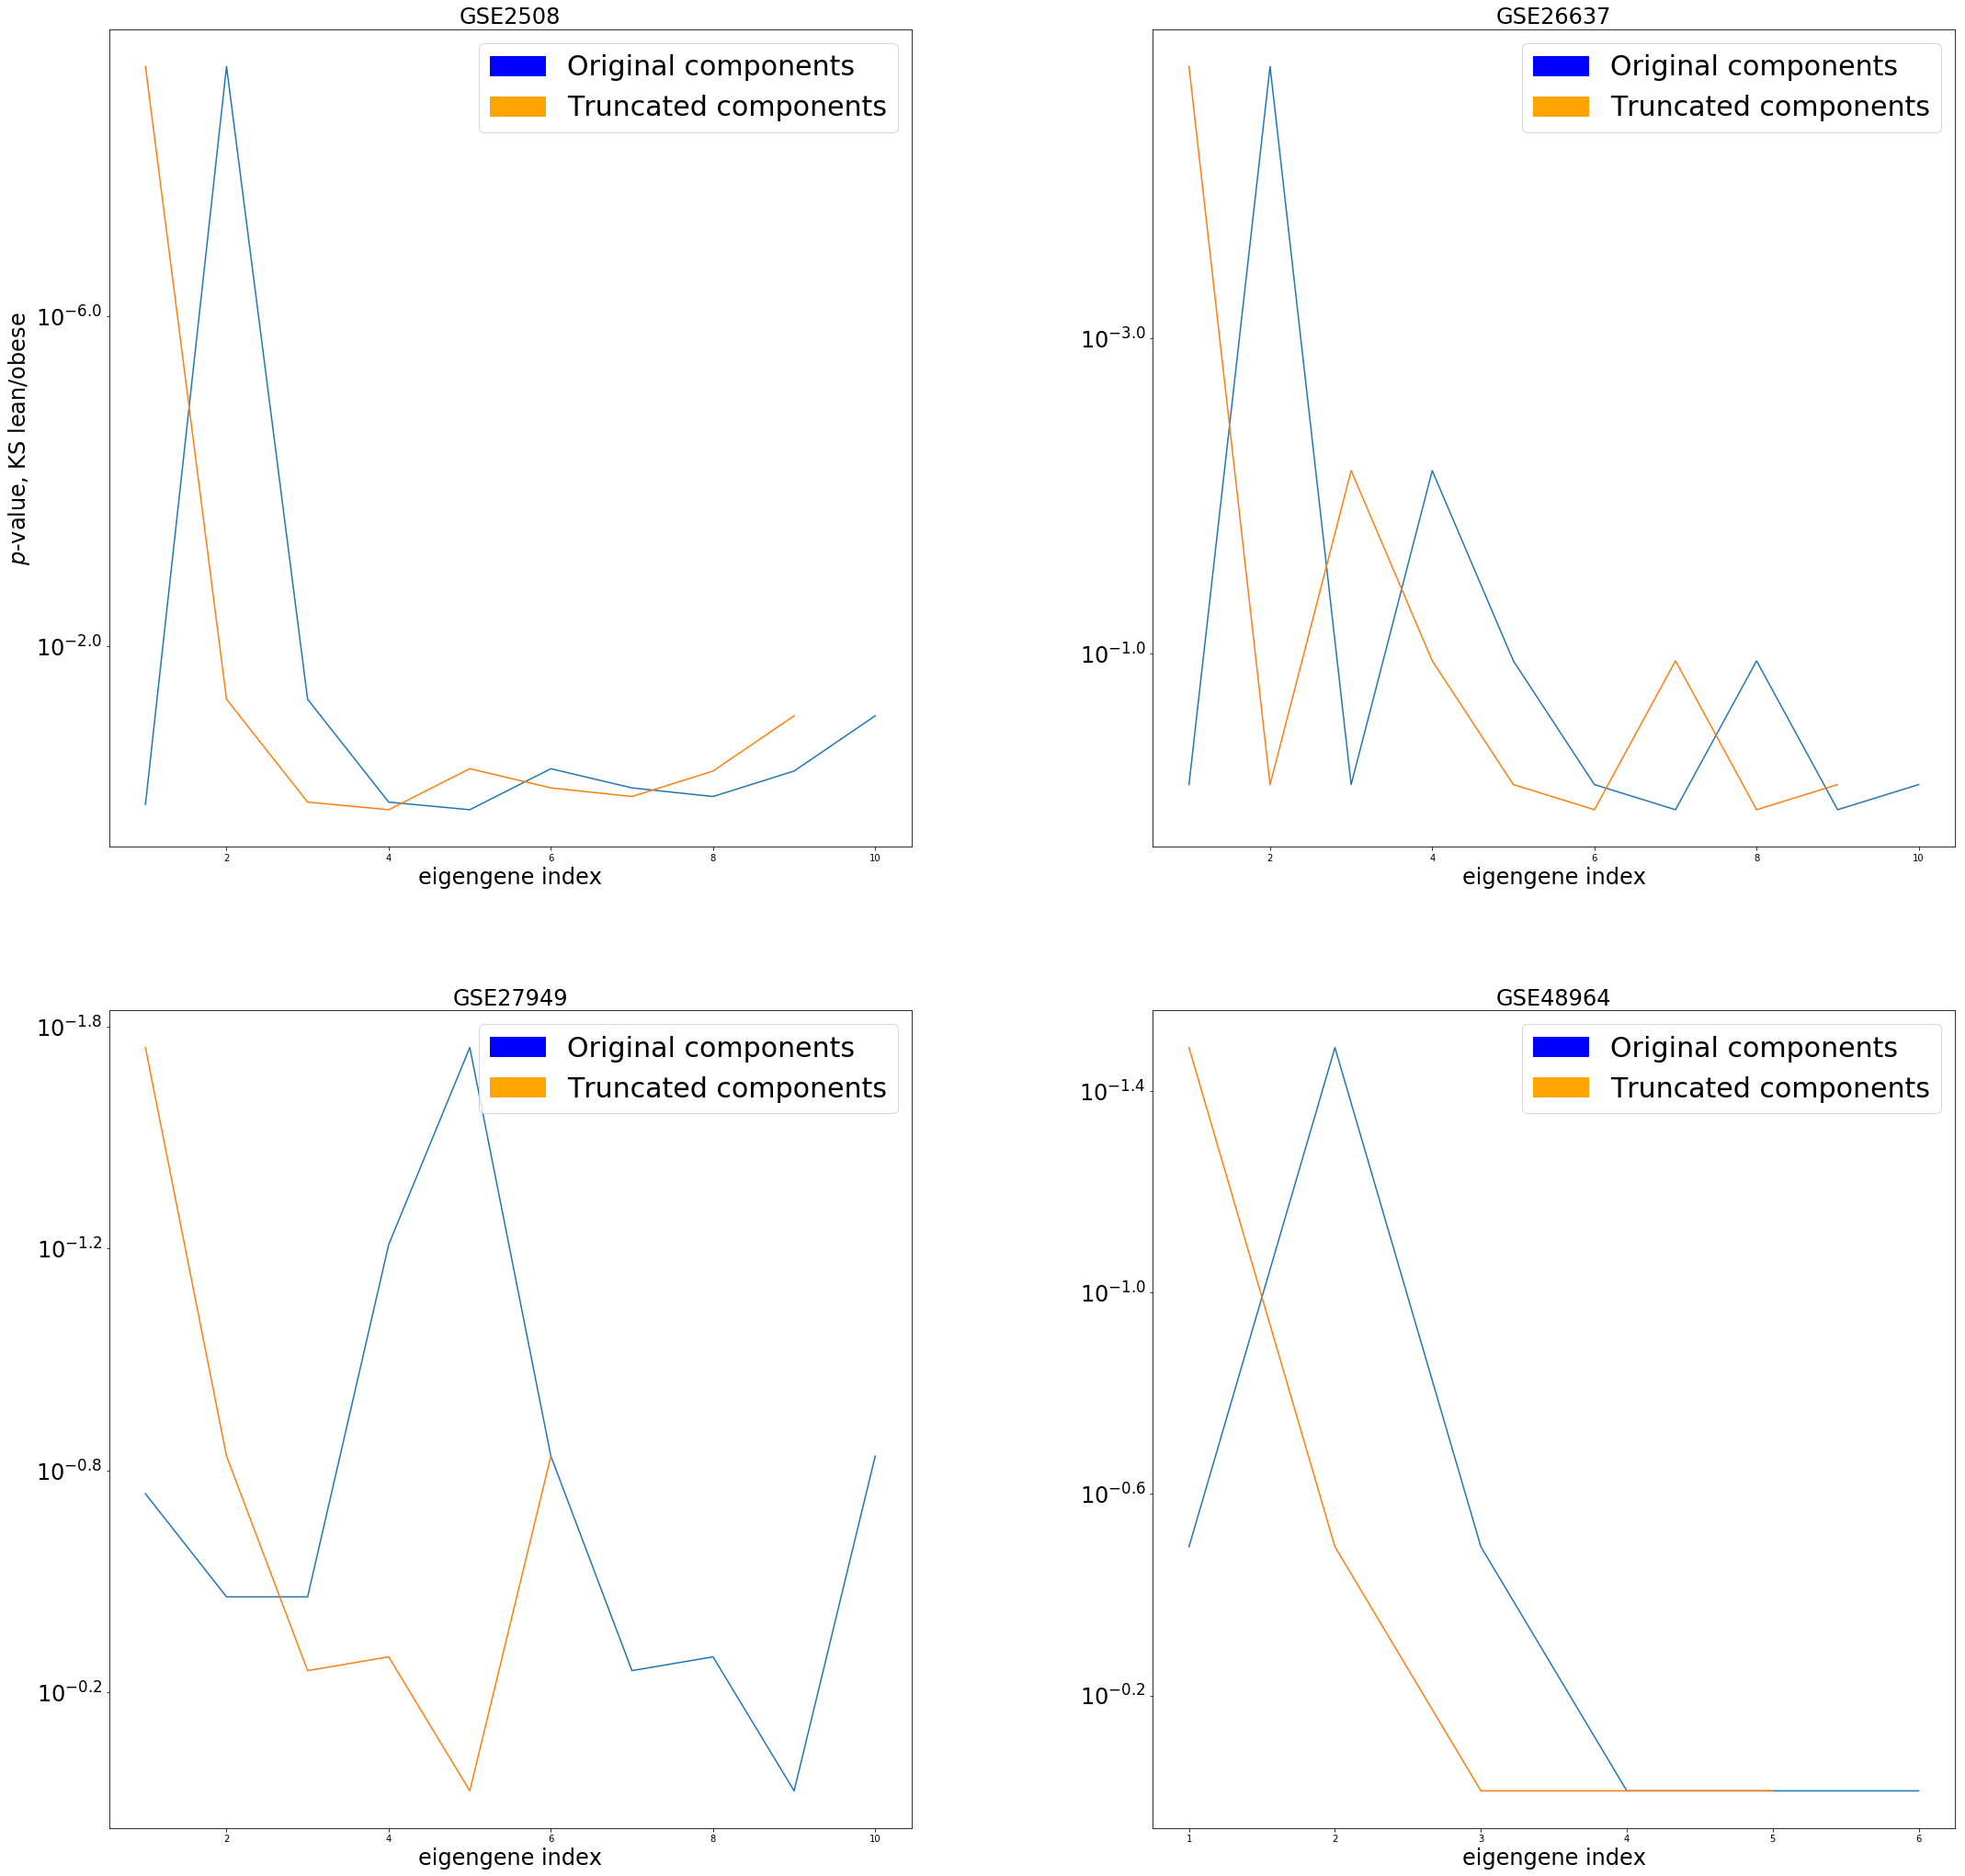

In [5]:
plt.figure(figsize=(36,36))

batches_df_without_first_components = []

for i,batch in enumerate(batches_df):
    # plot stuff
    plt.subplot(2,2,i+1)
    plt.title(list_of_dataset_to_load[i],size=24)
    plt.xlabel("eigengene index",size=24)
    if i==0: plt.ylabel("$p$-value, KS lean/obese",size=24)
        
    # call find_index_first_representative_component
    effect_strength, df_trans, model = find_index_first_representative_component(batch, method="SVD")
    effect_strength = effect_strength[1]
    
    # get max_val (l)
    max_val = (list(effect_strength).index(max(effect_strength)))
    
    # set 0 all l-1 columns
    df_trans.iloc[:,0:max_val] = 0
    
    # back to genes space
    batch_df_without_components_t = model.inverse_transform(df_trans)
    
    # convert from numpy to dataframe (rows are samples, columns are genes yet)
    batch_df_without_components_t = pd.DataFrame(data = batch_df_without_components_t,
                                                columns = batch.index,
                                                index = df_trans.index)
    
    # fill nan with zeros
    # batch_df_without_components_t = batch_df_without_components_t.fillna(value=0)
    
    # do the transpose and save it back again
    batches_df_without_first_components.append(batch_df_without_components_t.transpose())
    
    # plot stuff
    y = np.log10(effect_strength)
    plt.plot(range(1,y.shape[0]+1),y)
    yticks = plt.yticks()[0][::2]
    plt.yticks(yticks,["$10^{-%1.1f}$"%i for i in yticks],fontsize=24)
    plt.subplots_adjust(wspace=0.3)
    
    # plot again ignoring the first l-1 components
    # NOTES: theoretically, we have to call find_index_first_representative_component
    # and plot the results, the following is just to have a quick idea of effect
    y = np.log10(effect_strength[max_val:])
    plt.plot(range(1,y.shape[0]+1),y)
    
    blue_patch = mpatches.Patch(color='blue', label='Original components')
    orange_patch = mpatches.Patch(color='orange', label='Truncated components')
    plt.legend(handles=[blue_patch, orange_patch], prop={'size': 30})

In [6]:
print("One of the batch after intrinsic error removal")
batches_df_without_first_components[0].head()

One of the batch after intrinsic error removal


,GSM47301_LM,GSM47856_OM,GSM47568_LF,GSM47840_LM,GSM47362_LM,GSM47581_OF,GSM47372_OF,GSM47395_LF,GSM47561_LF,GSM47326_OF,...,GSM47398_LM,GSM47415_OF,GSM47839_LM,GSM47357_LM,GSM47414_OF,GSM47405_LM,GSM47225_LF,GSM47598_OM,GSM47352_LF,GSM47378_OM
ENTREZ_GENE_ID,,,,,,,,,,,,,,,,,,,,,
1,0.219867,0.628842,-0.287130,-0.894982,-0.628953,0.941583,0.132882,0.472665,0.617095,-0.269268,...,-0.520109,0.035672,-0.389564,-0.474100,-0.090283,-0.751917,-0.136432,0.068606,-0.158061,0.547978
10,-0.769587,0.390521,-0.125220,-0.132645,-0.574795,0.800169,-0.672118,0.878585,1.038871,-0.833516,...,-0.298796,-0.603363,-0.513395,-0.216293,-0.162971,-0.252292,0.174250,-0.222005,-0.255009,0.818220
100,-0.053171,-0.111448,-0.015019,-0.145725,0.011944,0.209093,0.326329,-0.266306,-0.014117,0.479808,...,-0.698745,0.316018,0.094566,0.156110,0.027934,0.221272,0.163992,0.020026,-0.236733,-0.211091
1000,0.505705,-0.445228,-0.336145,0.516393,-0.170601,0.157807,0.142567,0.445253,0.209353,-0.582155,...,-0.298475,-0.418434,0.636596,0.467772,-0.022900,0.474422,-0.051864,0.076186,-0.269874,-0.189995
10000,-0.032996,0.052237,0.085328,-0.098665,0.129817,-0.175435,-0.038044,-0.095194,-0.188089,0.238326,...,0.326037,0.130912,-0.371982,-0.434874,0.153054,-0.370901,-0.131927,0.028487,0.104289,0.034060


Shape after concatenation: (23634, 88)
Shape after rows with na: (15452, 88)


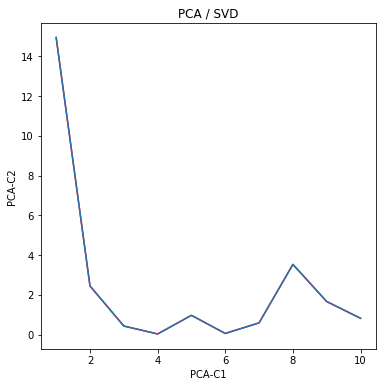

In [7]:
# merge new batches after intrinsic error removal
merged_df_without_first_components = pd.concat(batches_df_without_first_components, axis='columns')
print("Shape after concatenation:", merged_df_without_first_components.shape)
merged_df_without_first_components = merged_df_without_first_components.dropna(axis='rows', how='any')
print("Shape after rows with na:", merged_df_without_first_components.shape)

# apply again svd to notice the batch effect
effect_strength, df_trans, model = find_index_first_representative_component(merged_df_without_first_components, method="SVD")

plt.figure(figsize=[6,6])
plt.plot(range(1, 11), np.log10(effect_strength[1]), c='red')
plt.ylabel('PCA-C2')
plt.xlabel('PCA-C1')
plt.title("PCA / SVD")

# === Remove batch effect ===
effect_strength = effect_strength[1]

# get max_val (l)
max_val = (list(effect_strength).index(max(effect_strength)))

# set 0 all l-1 columns
df_trans.iloc[:,0:max_val] = 0

# plot again ignoring the first l-1 components
# NOTES: theoretically, we have to call find_index_first_representative_component
# and plot the results, the following is just to have a quick idea of effect
y = np.log10(effect_strength[max_val:])
plt.plot(range(1,y.shape[0]+1),y)
plt.show()

# back to genes space
batch_df_without_components_t = model.inverse_transform(df_trans)

# convert from numpy to dataframe (rows are samples, columns are genes yet)
batch_df_without_components_t = pd.DataFrame(data = batch_df_without_components_t,
                                                    columns = merged_df_without_first_components.index,
                                                    index = df_trans.index)

# do the transpose and save it back again
merged_df_no_batch_effect = batch_df_without_components_t.transpose()

In [8]:
print("Merged batches after batch effect removal")
merged_df_no_batch_effect.head()

Merged batches after batch effect removal


,GSM47301_LM,GSM47856_OM,GSM47568_LF,GSM47840_LM,GSM47362_LM,GSM47581_OF,GSM47372_OF,GSM47395_LF,GSM47561_LF,GSM47326_OF,...,GSM691126_OU,GSM691154_LU,GSM691134_OU,GSM691144_OU,GSM1187676_LU,GSM1187673_OU,GSM1187674_OU,GSM1187678_LU,GSM1187675_OU,GSM1187677_LU
1,-0.140635,0.431940,-0.076855,-0.639255,-0.419917,0.638952,-0.003946,0.379654,0.571354,-0.137532,...,0.080789,-0.201326,0.021607,0.030011,-0.069251,0.046684,0.024552,0.005445,-0.016250,0.008814
10,-0.799238,0.604769,-0.100966,-0.358237,-0.555201,0.658783,-0.649184,0.498678,0.878653,-0.776207,...,-0.025691,-0.059803,-0.011483,0.080270,-0.057468,0.039838,-0.045792,0.052911,-0.050405,0.060771
100,-0.171903,-0.154189,-0.006740,-0.029330,0.066475,0.237026,0.222490,-0.305934,0.019359,0.556013,...,0.012603,0.047955,-0.010611,-0.021988,0.070012,-0.019142,-0.044829,-0.034088,0.026769,0.001273
1000,0.337182,-0.388032,-0.251751,0.430990,-0.156279,0.064329,0.122549,0.299620,0.197685,-0.548237,...,0.036723,-0.018053,0.012789,-0.044818,-0.088555,0.032707,0.086241,-0.014346,0.028456,-0.044386
10000,-0.030492,0.145910,0.067840,-0.194479,0.105579,-0.155463,-0.032684,-0.192466,-0.208288,0.246152,...,0.020005,-0.040914,0.005904,0.003354,0.054945,-0.022084,-0.043038,0.008984,-0.022968,0.024098


In [9]:
# Because we are interested in collapse the dimension of the sample and not the one of the genes
merged_df_t = merged_df_no_batch_effect.transpose()

# apply a Standardization first
merged_df_std = StandardScaler().fit_transform(merged_df_t)

# define the PCA object, using 3 components
pca = PCA(n_components=3, svd_solver="full", whiten=True)

# apply the PCA on our dataset
pca_trans = pca.fit_transform(merged_df_std)
print('variance_ratio', pca.explained_variance_ratio_)
print('variance', pca.explained_variance_)

# create a dataframe from pca results
pca_trans_df = pd.DataFrame(data=pca_trans, index=merged_df_t.index)


# plot pca results with respect to the batch
batch_color = []
dict_of_colors = {}

list_of_colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', 'w']
color_per_sample = [list_of_colors[x] for x in person_batch_index]

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
blue_patch = mpatches.Patch(color='blue', label='GSE2508')
green_patch = mpatches.Patch(color='green', label='GSE26637')
red_patch = mpatches.Patch(color='red', label='GSE27949')
yellow_patch = mpatches.Patch(color='yellow', label='GSE48964')
ax.scatter(pca_trans_df[0], pca_trans_df[1], pca_trans_df[2], c=color_per_sample)
ax.set_xlabel('X: PCA-C1')
ax.set_ylabel('Y: PCA-C2')
ax.set_zlabel('Z: PCA-C3')
plt.title("PCA plot respect to batch")
plt.legend(handles=[blue_patch, green_patch, red_patch, yellow_patch])
plt.savefig(plot_dir_path + 'PCA_merged_std.pdf', format="pdf")
plt.close(fig)
print("-> Created 3D plot in ./plot/PCA_merged_std.pdf")

variance_ratio [ 0.1723043   0.15662985  0.12367944]
variance [ 2693.04892016  2448.06332584  1933.06127098]
-> Created 3D plot in ./plot/PCA_merged_std.pdf


In [10]:
import pickle

data_dir_path = './data/'
if not os.path.exists(plot_dir_path):
    os.makedirs(plot_dir_path)
    print('created ./path directory')

file_path = data_dir_path + 'merged_df_no_batch_effect.pkl'
merged_df_no_batch_effect.to_pickle(file_path)
print("Saved into", file_path)

Saved into ./data/merged_df_no_batch_effect.pkl
